In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import os

In [2]:
os.chdir(r'C:\Users\hp\Desktop\FPA\DS\ML\Anomaly Detection')

In [3]:
data = pd.read_csv('Iris.csv')
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
features = ["PetalLengthCm", "PetalWidthCm"] 

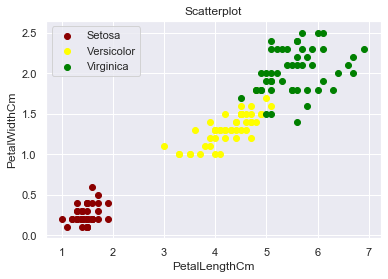

In [5]:
color_dict = {"Iris-setosa": "darkred",
"Iris-versicolor": "Yellow",
"Iris-virginica": "Green"}

names_dict = {"Iris-setosa": "Setosa",
"Iris-versicolor": "Versicolor",
"Iris-virginica": "Virginica"}

for species in color_dict.keys():
    plt.scatter(data[data.Species==species][features[0]],
    data[data.Species==species][features[1]],
    c=color_dict[species],
    label=names_dict[species])


plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title("Scatterplot")
plt.legend() 

In [6]:
def get_outliers(log_prob, epsilon):
    outliners = np.where(log_prob <= epsilon, 1, 0)
    return outliners 

In [7]:
def make_density_plot(data, features, model, outliers):
    
    x = np.linspace(data[features[0]].min(), data[features[0]].max())
    y = np.linspace(data[features[1]].min(), data[features[1]].max())
    X, Y = np.meshgrid(x, y)

    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = model.score_samples(XX)
    Z = Z.reshape(X.shape)

    levels = MaxNLocator(nbins=100).tick_values(Z.min(), Z.max()) 
    cmap = plt.get_cmap('BuGn')

    plt.figure(figsize=(10,10))
    plt.contourf(X, Y, Z.reshape(X.shape), cmap=cmap, levels=levels) 
    plt.scatter(model.means_[:,0], model.means_[:,1], color="Blue")
    g1 = plt.scatter(data[data.Outlier==0][features[0]].values,
    data[data.Outlier==0][features[1]].values, label="Normal",s=4.0,c="Pink")
    g2 = plt.scatter(data[data.Outlier==1][features[0]].values,
    data[data.Outlier==1][features[1]].values, label="Abnormal",s=4.5,c="Black")
    plt.legend(handles=[g1,g2]) 
    
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    return plt

In [8]:
X_train = data[features].values

model = GaussianMixture(n_components=3, covariance_type="full")
model.fit(X_train)
log_prob = model.score_samples(X_train)
outliers = get_outliers(log_prob, 0.15)
data["Outlier"] = outliers 

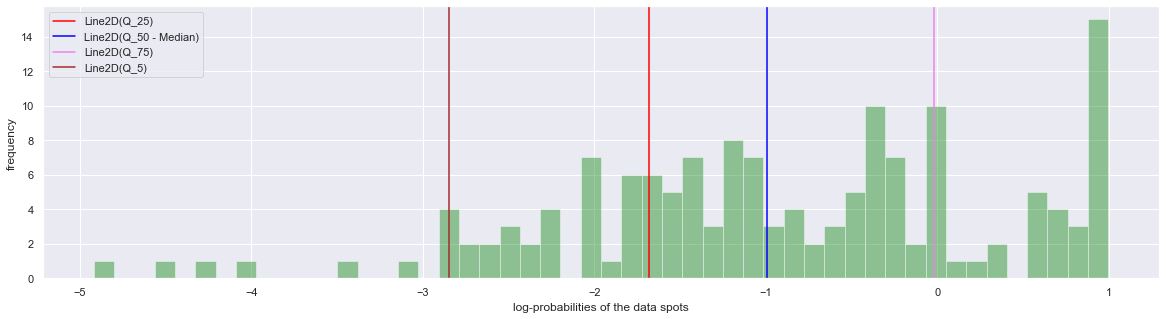

In [9]:
plt.figure(figsize=(20,5))

sns.distplot(log_prob, kde=False, bins=50, color="Green")
g1 = plt.axvline(np.quantile(log_prob, 0.25), color="Red", label="Q_25")
g2 = plt.axvline(np.quantile(log_prob, 0.5), color="Blue", label="Q_50 - Median")
g3 = plt.axvline(np.quantile(log_prob, 0.75), color="Violet", label="Q_75")
g4 = plt.axvline(np.quantile(log_prob, 0.05), color="Brown", label="Q_5")
handles = [g1, g2, g3, g4]
plt.xlabel("log-probabilities of the data spots")
plt.ylabel("frequency")
plt.legend(handles) 

In [10]:
epsilon = np.quantile(log_prob, 0.05)
print("epsilon: %f" % epsilon)

epsilon: -2.850353


In [11]:
outliers = get_outliers(log_prob, epsilon)
data["Outlier"] = outliers

<module 'matplotlib.pyplot' from 'D:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

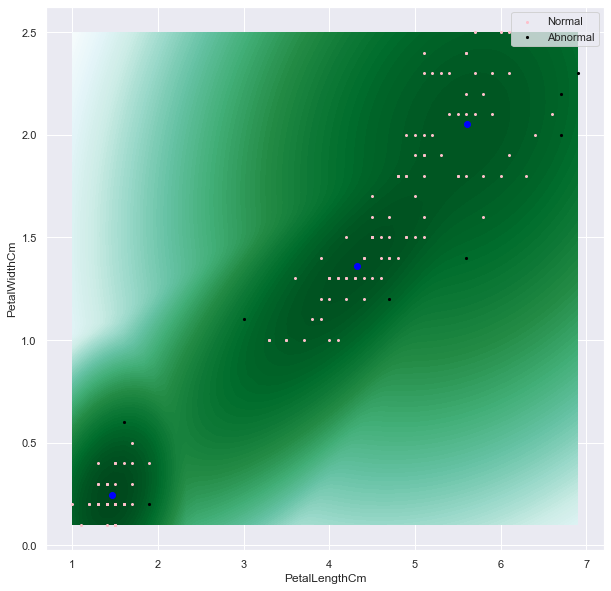

In [12]:
make_density_plot(data, features, model, outliers)

In [13]:
data.head() 
data.Outlier.value_counts() 

0    142
1      8
Name: Outlier, dtype: int64

In [14]:
species_probas = np.round(model.predict_proba(X_train),2)
best_species_idx = np.argmax(species_probas,axis=1)
data["Predicted"] = best_species_idx

In [15]:
def map_to_species(data, features):
    grouped = data.groupby("Species")[features].mean()
    feature_means = grouped.values
    
    names_map = {}
    for m in data.Predicted.unique():
        predicted_mean = data[data.Predicted == m][features].mean().values
        distances = np.zeros(feature_means.shape[0])
    
        for f in range(feature_means.shape[0]):
            distances[f] = np.linalg.norm(predicted_mean - feature_means[f])
        name = grouped.index.values[np.argmin(distances)]
        names_map[m] = name  
    
    return names_map

In [16]:
names_map = map_to_species(data, features)

In [17]:
data["Predicted_Species"] = data["Predicted"].apply(lambda l: names_map[l])

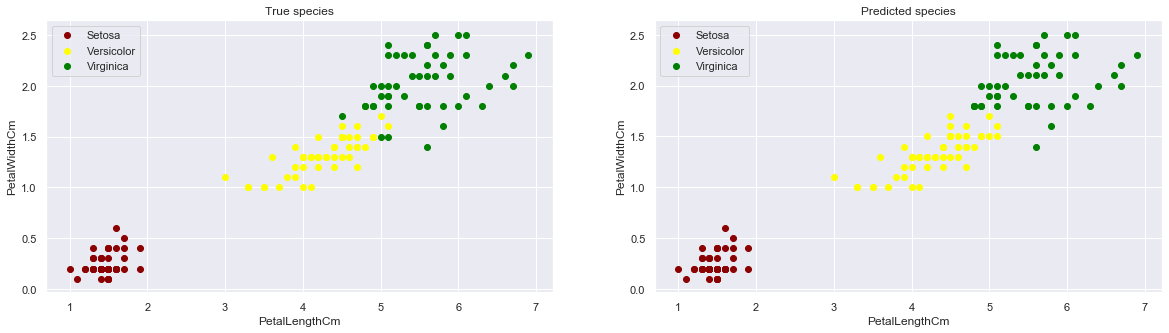

In [18]:
ig, ax = plt.subplots(1,2,figsize=(20,5))

for species in color_dict.keys():
    ax[0].scatter(data[data.Species==species][features[0]],
                data[data.Species==species][features[1]],
                c=color_dict[species],
                label=names_dict[species])
    ax[1].scatter(data[data.Predicted_Species==species][features[0]],
                data[data.Predicted_Species==species][features[1]],
                c=color_dict[species],
                label=names_dict[species])

ax[0].set_xlabel(features[0])
ax[0].set_ylabel(features[1])
ax[0].set_title("True species")
ax[0].legend()

ax[1].set_xlabel(features[0])
ax[1].set_ylabel(features[1])
ax[1].set_title("Predicted species")
ax[1].legend()

In [19]:
color = np.zeros(best_species_idx.shape[0])
for n in range(len(color)):
    color[n] = species_probas[n,best_species_idx[n]]

In [20]:
data["Correctness"] = np.where(data.Predicted_Species == data.Species, 1, 0)

Text(0.5, 1.0, 'Correctness of species-predictions')

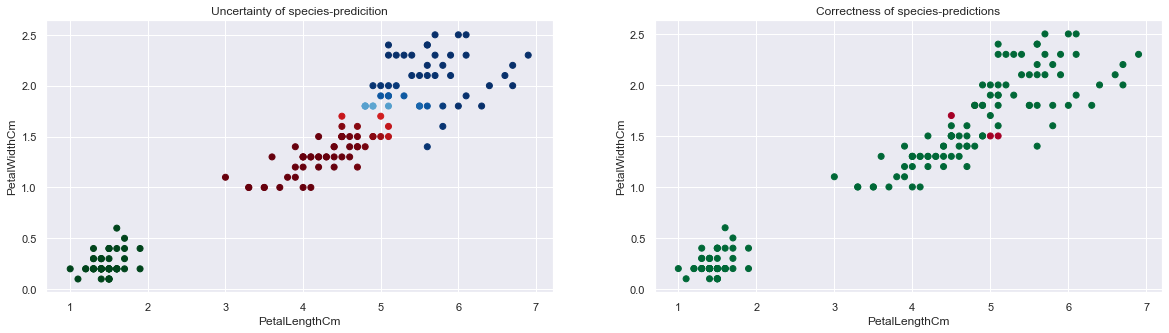

In [21]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(data[data.Predicted == 0][features[0]],
            data[data.Predicted == 0][features[1]],
            c=color[data.Predicted == 0],
            cmap="Reds", 
            vmin=0, 
            vmax=1)
ax[0].scatter(data[data.Predicted == 1][features[0]],
            data[data.Predicted == 1][features[1]],
            c=color[data.Predicted == 1],
            cmap="Greens", 
            vmin=0, 
            vmax=1)
ax[0].scatter(data[data.Predicted == 2][features[0]],
            data[data.Predicted == 2][features[1]],
            c=color[data.Predicted == 2],
            cmap="Blues", 
            vmin=0, 
            vmax=1)
ax[0].set_xlabel(features[0])
ax[0].set_ylabel(features[1])
ax[0].set_title("Uncertainty of species-predicition")
ax[1].scatter(data[features[0]],
              data[features[1]],
              c=data.Correctness.values,
              cmap="RdYlGn", vmin=0,vmax=1 )
ax[1].set_xlabel(features[0])
ax[1].set_ylabel(features[1])
ax[1].set_title("Correctness of species-predictions")

Text(0.5, 1.0, 'Correctness of species-predictions')

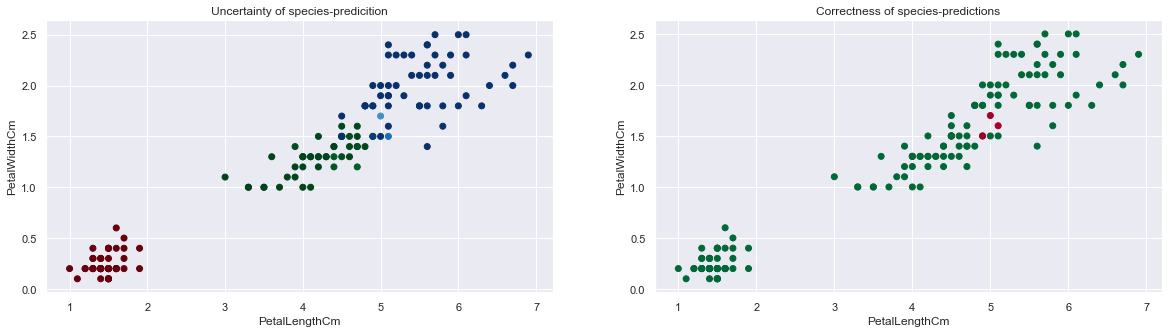

In [22]:
all_features = ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]

Y_train = data[all_features].values


model_all = GaussianMixture(n_components=3, covariance_type="full")
model_all.fit(Y_train)
new_log_prob = model_all.score_samples(Y_train)
outliers = get_outliers(new_log_prob, 0.15)
data["Outlier"] = outliers

species_probas_all = np.round(model_all.predict_proba(Y_train),2)
best_species_all_idx = np.argmax(species_probas_all,axis=1)
data["Predicted"] = best_species_all_idx

def map_to_species(data, features):
    grouped = data.groupby("Species")[all_features].mean()
    all_feature_means = grouped.values
    
    names_map = {}
    for m in data.Predicted.unique():
        all_predicted_mean = data[data.Predicted == m][all_features].mean().values
        all_distances = np.zeros(all_feature_means.shape[0])
    
        for f in range(all_feature_means.shape[0]):
            all_distances[f] = np.linalg.norm(all_predicted_mean - all_feature_means[f])
        name = grouped.index.values[np.argmin(all_distances)]
        names_map[m] = name  
    
    return names_map

names_map = map_to_species(data, all_features)

data["Predicted_Species"] = data["Predicted"].apply(lambda l: names_map[l])

color = np.zeros(best_species_all_idx.shape[0])
for n in range(len(color)):
    color[n] = species_probas_all[n,best_species_all_idx[n]]

data["Correctness"] = np.where(data.Predicted_Species == data.Species, 1, 0)

fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(data[data.Predicted == 0][features[0]],
            data[data.Predicted == 0][features[1]],
            c=color[data.Predicted == 0],
            cmap="Reds", 
            vmin=0, 
            vmax=1)
ax[0].scatter(data[data.Predicted == 1][features[0]],
            data[data.Predicted == 1][features[1]],
            c=color[data.Predicted == 1],
            cmap="Greens", 
            vmin=0, 
            vmax=1)
ax[0].scatter(data[data.Predicted == 2][features[0]],
            data[data.Predicted == 2][features[1]],
            c=color[data.Predicted == 2],
            cmap="Blues", 
            vmin=0, 
            vmax=1)
ax[0].set_xlabel(features[0])
ax[0].set_ylabel(features[1])
ax[0].set_title("Uncertainty of species-predicition")
ax[1].scatter(data[features[0]],
              data[features[1]],
              c=data.Correctness.values,
              cmap="RdYlGn", vmin=0,vmax=1 )
ax[1].set_xlabel(features[0])
ax[1].set_ylabel(features[1])
ax[1].set_title("Correctness of species-predictions")

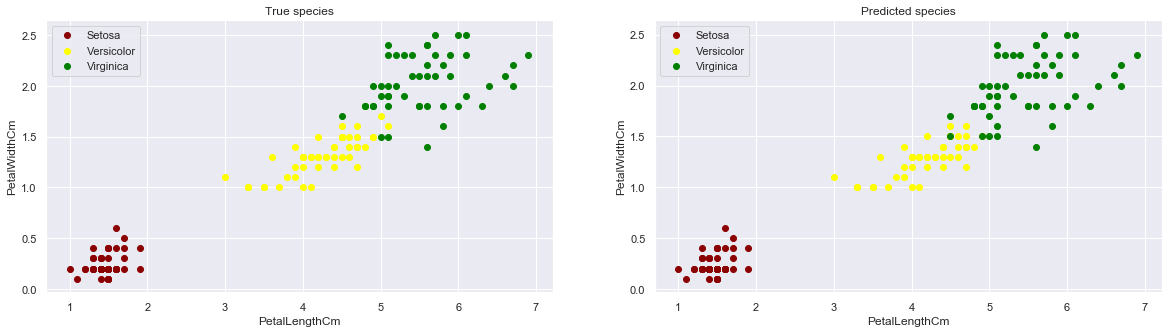

In [23]:
ig, ax = plt.subplots(1,2,figsize=(20,5))

for species in color_dict.keys():
    ax[0].scatter(data[data.Species==species][features[0]],
                data[data.Species==species][features[1]],
                c=color_dict[species],
                label=names_dict[species])
    ax[1].scatter(data[data.Predicted_Species==species][features[0]],
                data[data.Predicted_Species==species][features[1]],
                c=color_dict[species],
                label=names_dict[species])

ax[0].set_xlabel(features[0])
ax[0].set_ylabel(features[1])
ax[0].set_title("True species")
ax[0].legend()

ax[1].set_xlabel(features[0])
ax[1].set_ylabel(features[1])
ax[1].set_title("Predicted species")
ax[1].legend()